# Electron-positron annihilation into photons

In this notebook, we will consider the process $e^+e^- \to 2\gamma$. We prepare an electron-positron pair in some initial quantum state, and we study the quantum state of the emitted photon pair. Initially, we consider the scattering from the CM frame, after which we will perform a boost in the $z$-direction. We start by importing `qedtool` and `numpy`, and some libraries required for making plots:

In [1]:
import numpy as np
import qedtool as qtl
import matplotlib.pyplot as plt

We will define the electron mass in MeV and the elementary charge:

In [2]:
m = qtl.constant("electron mass")
e = qtl.constant("elementary charge")

In the CM frame, the electron and positron have the same 3-momentum norm $|\mathbf{p}|$, which we will set to 0.2 MeV. We will calculate the emitted two-photon state for all angles $\theta$ and $\phi$. Therefore we need to define:

In [3]:
p = 0.2
energy = np.sqrt(p**2 + m**2)
phi = np.linspace(0, 2*np.pi, 50)
theta = np.linspace(0, np.pi, 50)

The electron and positron have their momenta in opposite directions, and we will choose the collision axis to be the $z$-axis:

In [4]:
pmu_e = qtl.FourVector(energy, p, 0, 0)
pmu_p = -pmu_e

The initial quantum state will be a mixed state with density matrix $\rho = w_1|\psi_1\rangle\langle\psi_1| + w_2|\psi_2\rangle\langle\psi_2|$ where

$$|\psi_1\rangle = \frac{1}{\sqrt{2}}\Big( |p_+,\mathrm{L};p_-,\mathrm{R}\rangle + |p_+,\mathrm{H};p_-,\mathrm{V}\rangle \Big)\,, \qquad\quad |\psi_2\rangle = \vphantom{\frac{1}{1}}|p_+,\mathrm{R};p_-,\mathrm{R}\rangle\,,$$

with $w_1 = \frac{2}{5}$ and $w_2 = \frac{3}{5}$. Here, $p_\pm = (\varepsilon_\mathbf{p}, \pm|\mathbf{p}|\hat{\mathbf{z}})$ is the electron(positron) 4-momentum; the ''$\pm$'' stands for the direction of the 3-momentum, not the charge of the Dirac fermions! To construct the mixed state, we therefore need to define the following single-particle states:

In [5]:
plus_l = qtl.QuantumState.single(pmu_e, "L")
plus_r = qtl.QuantumState.single(pmu_e, "R")
plus_h = qtl.QuantumState.single(pmu_e, "H")
minus_r = qtl.QuantumState.single(pmu_p, "R")
minus_v = qtl.QuantumState.single(pmu_p, "V")
minus_l = qtl.QuantumState.single(pmu_p, "L")

From these, we can constuct the mixed initial electron-positron state:

In [6]:
# Pure state components
state_1 = (plus_l * minus_r + plus_h * minus_v) / np.sqrt(2)
state_2 = plus_r * minus_r
states = [state_1, state_2]

# Classical probabilities
w = [0.4, 0.6]

# Creating the mixed initial state
in_state = qtl.QuantumState.mixed(w, states)

Both initial Dirac fermions have a speed $|\boldsymbol{\beta}_{\text{CM}}|$ equal to

In [7]:
beta_cm = qtl.ThreeVector.beta(pmu_e)
print("v =", np.sqrt(beta_cm * beta_cm))

v = 0.3644680589773209


To calculate the polarized Feynman amplitudes, we generate a 2-dimensional array with all handedness combinations:

In [8]:
hand_ll = qtl.handedness_config(4, [2, 3], [-1, -1])
hand_lr = qtl.handedness_config(4, [2, 3], [-1, 1])
hand_rl = qtl.handedness_config(4, [2, 3], [1, -1])
hand_rr = qtl.handedness_config(4, [2, 3], [1, 1])

h = [hand_ll, hand_lr, hand_rl, hand_rr]

For example, in `hand_ll` we fixed the emitted photon helicities to be both $-1$. We will calculate twelve quantities: the differential cross section $\partial_\Pi\sigma$, the two-photon concurrence $C$, the two-photon degree of polarization $P_{(2)}$, and nine Stokes parameters. For this we generate twelve empty lists:

In [9]:
data = qtl.empty_lists(12)

Here we will perform the main calculation:

In [10]:
for ph in range(len(phi)):
    
    data_ph = qtl.empty_lists(12)
    
    for i in range(len(theta)):

        amplitudes = []

        for j in range(len(h)):

            amplitudes_row = []

            for k in range(len(h[j])):

                # Photon pair 4-momenta
                kmu_1 = qtl.FourVector(energy, energy, theta[i], phi[ph])
                kmu_2 = -kmu_1

                # Virtual 4-momenta
                qmu_1 = pmu_e - kmu_1
                qmu_2 = pmu_e - kmu_2

                # External particles for polarized Feynman amplitudes
                electron = qtl.RealParticle.electron(h[j][k][0], pmu_e, "in")
                positron = qtl.RealParticle.positron(h[j][k][1], pmu_p, "in")
                photon_1 = qtl.RealParticle.photon(h[j][k][2], kmu_1, "out")
                photon_2 = qtl.RealParticle.photon(h[j][k][3], kmu_2, "out")
                
                # Virtual particles
                fermion_1 = qtl.VirtualParticle.electron(qmu_1)
                fermion_2 = qtl.VirtualParticle.electron(qmu_2)
                
                # Retrieve fermion polarizations
                u = electron.polarization.bispinor
                v = positron.polarization.bispinor
                
                # Photon polarization matrices
                e1 = -1j * e * qtl.slashed(photon_1.polarization)
                e2 = -1j * e * qtl.slashed(photon_2.polarization)
                
                # Retrieve propagators
                g1 = fermion_1.propagator
                g2 = fermion_2.propagator
                
                # Calculate the total amplitude
                amplitude = v.dot(e2).dot(g1).dot(e1).dot(u) \
                            + v.dot(e1).dot(g2).dot(e2).dot(u)
                
                amplitudes_row.append(amplitude)
            
            amplitudes.append(amplitudes_row)
            
        # Construct the emitted state from the initial state
        out = qtl.QuantumState.out_state(in_state, amplitudes)
        
        # Compute the 12 quantities
        dcs = qtl.diff_cross_section(pmu_e, pmu_p, out)
        conc = qtl.concurrence(out)
        pol = qtl.degree_polarization(out)
        s11 = qtl.stokes_parameter(out, [1, 1])
        s12 = qtl.stokes_parameter(out, [1, 2])
        s13 = qtl.stokes_parameter(out, [1, 3])
        s21 = qtl.stokes_parameter(out, [2, 1])
        s22 = qtl.stokes_parameter(out, [2, 2])
        s23 = qtl.stokes_parameter(out, [2, 3])
        s31 = qtl.stokes_parameter(out, [3, 1])
        s32 = qtl.stokes_parameter(out, [3, 2])
        s33 = qtl.stokes_parameter(out, [3, 3])
            
        quantities = [dcs, conc, pol, 
                      s11, s12, s13,
                      s21, s22, s23,
                      s31, s32, s33]
        
        for l in range(len(data_ph)):
            data_ph[l].append(quantities[l])
                
    for n in range(len(data)):
        data[n].append(data_ph[n])


Now we can plot the results:

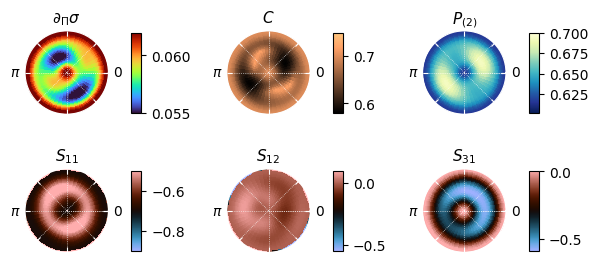

In [11]:
# Figure
cm = 1 / 2.54
fig, ax = plt.subplots(2, 3, subplot_kw={'projection': 'polar'}, constrained_layout=True)
fig.set_size_inches(15*cm, 7*cm)

# Plot data
im00 = ax[0,0].pcolormesh(phi, theta, np.transpose(data[0]), shading='auto', cmap='turbo', vmin = 0.055, vmax = 0.062)
im01 = ax[0,1].pcolormesh(phi, theta, np.transpose(data[1]), shading='auto', cmap='copper', vmin = 0.58, vmax = 0.75)
im02 = ax[0,2].pcolormesh(phi, theta, np.transpose(data[2]), shading='auto', cmap='YlGnBu_r', vmin = 0.6025, vmax = 0.7)
im10 = ax[1,0].pcolormesh(phi, theta, np.transpose(data[3]), shading='auto', cmap='berlin', vmin=-0.9, vmax=-0.5)
im11 = ax[1,1].pcolormesh(phi, theta, np.transpose(data[4]), shading='auto', cmap='berlin', vmin=0.1, vmax=-0.5)
im12 = ax[1,2].pcolormesh(phi, theta, np.transpose(data[9]), shading='auto', cmap='berlin')

# Show colorbar
plt.colorbar(im00, ax=ax[0,0], pad=0.1, aspect=8, fraction=0.12)
plt.colorbar(im01, ax=ax[0,1], pad=0.1, aspect=8, fraction=0.12)
plt.colorbar(im02, ax=ax[0,2], pad=0.1, aspect=8, fraction=0.12)
plt.colorbar(im10, ax=ax[1,0], pad=0.1, aspect=8, fraction=0.12)
plt.colorbar(im11, ax=ax[1,1], pad=0.1, aspect=8, fraction=0.12)
plt.colorbar(im12, ax=ax[1,2], pad=0.1, aspect=8, fraction=0.12)

# Make the radial axis invisible
for i in range(2):
    for j in range(3):
        ax[i,j].yaxis.set_visible(False)

# Titles
ax[0,0].set_title('$\partial_{\Pi}\\sigma$', fontsize=11);
ax[0,1].set_title('$C$', fontsize=11);
ax[0,2].set_title('$P_{(2)}$', fontsize=11);

ax[1,0].set_title('$S_{11}$', fontsize=11);
ax[1,1].set_title('$S_{12}$', fontsize=11);
ax[1,2].set_title('$S_{31}$', fontsize=11);

# White edge colors
for j in range(3):
    for spine in ax[0,j].spines.values():
        spine.set_edgecolor('white')
    for spine in ax[1,j].spines.values():
        spine.set_edgecolor('white')
        
# Azimuthal ticks and labels
xticks = [0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi, np.pi + np.pi/4, np.pi + np.pi/2, np.pi + 3*np.pi/4, 2*np.pi]
xlabels = ['$0$', '', '', '', '$\pi$', '', '', '', '']
for i in range(2):
    for j in range(3):
        ax[i,j].xaxis.set_ticks(xticks)
        ax[i,j].set_xticklabels(xlabels) 
        ax[i,j].tick_params(axis='both', which='both', direction='in', right=True, top=True, color='white', pad=0.05)
        ax[i,j].grid(color='white', linestyle=':', linewidth=0.5)

We can now observe the effect of a boost on the correlations above. We saw that the initial fermions move at $|\boldsymbol{\beta}_{\text{CM}}| \approx 0.36$. Therefore, a boost with $\boldsymbol{\beta} = (0, 0, 0.6)$ will induce a spin flip in the initial positron. First we define the boost 3-vector:

In [12]:
beta = qtl.ThreeVector(0.6, 0, 0)

With the following `for`-loop, we can extract the boosted polar angles $\theta_{\boldsymbol{\beta}}$ of a photon with 4-momentum $k = \varepsilon_\mathbf{p}(1,\sin\theta,0,\cos\theta)$ as a function of $\theta$.

In [13]:
theta_b = []
for j in range(len(theta)):
    kmu = qtl.FourVector(energy, energy, theta[j], 0)
    kmu_b = qtl.boost(kmu, beta)
    theta_b.append(kmu_b.sphericals[2])

When plotted as a function:

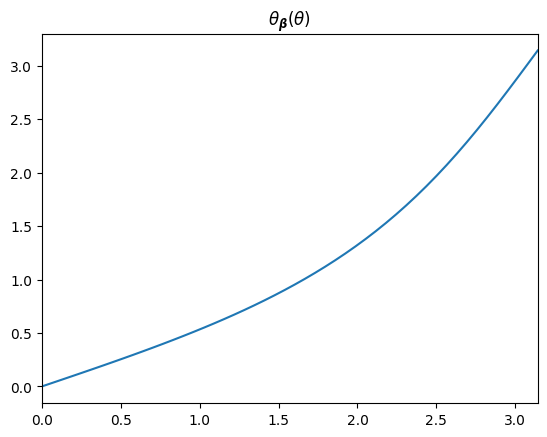

In [14]:
plt.plot(theta, theta_b);
plt.xlim(0, np.pi);
plt.title("$\\theta_{\\boldsymbol{\\beta}}(\\theta)$");

Naturally, the relation plotted above is not linear. By decreasing the boost factor, i.e. $|\boldsymbol{\beta}|\ll 1$, the function converges to $\theta_{\boldsymbol{\beta}}(\theta) \sim \theta$ as expected. To boost to a different frame, we boost the previously defined single-particle states:

In [15]:
plus_l_b = qtl.boost(plus_l, beta)
plus_r_b = qtl.boost(plus_r, beta)
plus_h_b = qtl.boost(plus_h, beta)
minus_r_b = qtl.boost(minus_r, beta)
minus_v_b = qtl.boost(minus_v, beta)

Then we construct the mixed state like before, except we use the boosted single-particle states:

In [16]:
# Boosted pure state components
state_1_b = (plus_l_b * minus_r_b + plus_h_b * minus_v_b) / np.sqrt(2)
state_2_b = plus_r_b * minus_r_b
states_b = [state_1_b, state_2_b]

# Classical probabilities
w = [0.4, 0.6]

# Creating the boosted mixed initial state
in_state_b = qtl.QuantumState.mixed(w, states_b)

As expected, we observe a difference in the original and boosted density matrices:

In [17]:
print("unboosted:")
print(np.round(in_state.rho,4))
print()
print("boosted:")
print(np.round(in_state_b.rho,4))

unboosted:
[[ 0.05+0.j  -0.05+0.1j  0.05+0.j  -0.05+0.j ]
 [-0.05-0.1j  0.25-0.j  -0.05-0.1j  0.05+0.1j]
 [ 0.05+0.j  -0.05+0.1j  0.05+0.j  -0.05+0.j ]
 [-0.05+0.j   0.05-0.1j -0.05+0.j   0.65+0.j ]]

boosted:
[[0.25-0.j  0.05+0.1j 0.05+0.1j 0.05+0.1j]
 [0.05-0.1j 0.05-0.j  0.05+0.j  0.05+0.j ]
 [0.05-0.1j 0.05-0.j  0.65+0.j  0.05+0.j ]
 [0.05-0.1j 0.05-0.j  0.05+0.j  0.05+0.j ]]


We proceed to construct the emitted state and correlations as in our previous calculation, except we assign the boosted initial quantum state as `in_state`. Users can verify that boosting all particles in the inner-most loop leaves the result unchanged.

In [18]:
# Boosted data lists
data_b = qtl.empty_lists(12)

# Boosted initial 4-momenta (needed for differential cross section)
pmu_e_b = qtl.boost(pmu_e, beta)
pmu_p_b = qtl.boost(pmu_p, beta)

for a in range(len(phi)):
    
    data_a = qtl.empty_lists(12)
    
    for i in range(len(theta)):

        amplitudes = []

        for j in range(len(h)):

            amplitudes_row = []

            for k in range(len(h[j])):

                # Photon pair 4-momenta
                kmu_1 = qtl.FourVector(energy, energy, theta[i], phi[a])
                kmu_2 = -kmu_1

                # Internal 4-momenta
                qmu_1 = pmu_e - kmu_1
                qmu_2 = pmu_e - kmu_2

                # External particles for polarized Feynman amplitudes
                electron = qtl.RealParticle.electron(h[j][k][0], pmu_e, "in")
                positron = qtl.RealParticle.positron(h[j][k][1], pmu_p, "in")
                photon_1 = qtl.RealParticle.photon(h[j][k][2], kmu_1, "out")
                photon_2 = qtl.RealParticle.photon(h[j][k][3], kmu_2, "out")
                
                # Internal particles
                fermion_1 = qtl.VirtualParticle.electron(qmu_1)
                fermion_2 = qtl.VirtualParticle.electron(qmu_2)
                
                # Retrieve fermion polarizations
                u = electron.polarization.bispinor
                v = positron.polarization.bispinor
                
                # Photon polarization matrices
                e1 = -1j * e * qtl.slashed(photon_1.polarization)
                e2 = -1j * e * qtl.slashed(photon_2.polarization)
                
                # Propagators
                g1 = fermion_1.propagator
                g2 = fermion_2.propagator
                
                # Calculate the total amplitude
                amplitude = v.dot(e2).dot(g1).dot(e1).dot(u) \
                            + v.dot(e1).dot(g2).dot(e2).dot(u)
                
                amplitudes_row.append(amplitude)
            
            amplitudes.append(amplitudes_row)
            
        out = qtl.QuantumState.out_state(in_state_b, amplitudes)
        
        dcs = qtl.diff_cross_section(pmu_e_b, pmu_p_b, out)
        conc = qtl.concurrence(out)
        pol = qtl.degree_polarization(out)
        s11 = qtl.stokes_parameter(out, [1, 1])
        s12 = qtl.stokes_parameter(out, [1, 2])
        s13 = qtl.stokes_parameter(out, [1, 3])
        s21 = qtl.stokes_parameter(out, [2, 1])
        s22 = qtl.stokes_parameter(out, [2, 2])
        s23 = qtl.stokes_parameter(out, [2, 3])
        s31 = qtl.stokes_parameter(out, [3, 1])
        s32 = qtl.stokes_parameter(out, [3, 2])
        s33 = qtl.stokes_parameter(out, [3, 3])
            
        quantities = [dcs, conc, pol, 
                      s11, s12, s13,
                      s21, s22, s23,
                      s31, s32, s33]
        
        for l in range(len(data_a)):
            data_a[l].append(quantities[l])
                
    for n in range(len(data_b)):
        data_b[n].append(data_a[n])


Again, we plot the results:

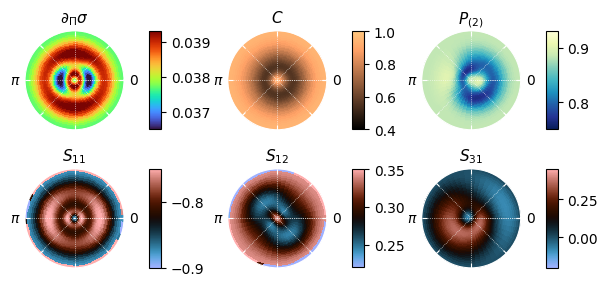

In [19]:
# Figure
cm = 1 / 2.54
fig, ax = plt.subplots(2, 3, subplot_kw={'projection': 'polar'}, constrained_layout=True)
fig.set_size_inches(15*cm, 7*cm)

# Plot data
im00 = ax[0,0].pcolormesh(phi, theta_b, np.transpose(data_b[0]), shading='auto', cmap='turbo', vmin=0.0365, vmax=0.0393)
im01 = ax[0,1].pcolormesh(phi, theta_b, np.transpose(data_b[1]), shading='auto', cmap='copper', vmin=0.4, vmax=1)
im02 = ax[0,2].pcolormesh(phi, theta_b, np.transpose(data_b[2]), shading='auto', cmap='YlGnBu_r', vmin=0.75, vmax=0.93)
im10 = ax[1,0].pcolormesh(phi, theta_b, np.transpose(data_b[3]), shading='auto', cmap='berlin', vmin=-0.9, vmax=-0.75)
im11 = ax[1,1].pcolormesh(phi, theta_b, np.transpose(data_b[4]), shading='auto', cmap='berlin', vmin=0.22, vmax=0.35)
im12 = ax[1,2].pcolormesh(phi, theta_b, np.transpose(data_b[9]), shading='auto', cmap='berlin', vmin=-0.2, vmax=0.45)

# Show colorbar
plt.colorbar(im00, ax=ax[0,0], pad=0.1, aspect=8, fraction=0.12)
plt.colorbar(im01, ax=ax[0,1], pad=0.1, aspect=8, fraction=0.12)
plt.colorbar(im02, ax=ax[0,2], pad=0.1, aspect=8, fraction=0.12)
plt.colorbar(im10, ax=ax[1,0], pad=0.1, aspect=8, fraction=0.12)
plt.colorbar(im11, ax=ax[1,1], pad=0.1, aspect=8, fraction=0.12)
plt.colorbar(im12, ax=ax[1,2], pad=0.1, aspect=8, fraction=0.12)

# Make the radial axis invisible
for i in range(2):
    for j in range(3):
        ax[i,j].yaxis.set_visible(False)

# Titles
ax[0,0].set_title('$\partial_{\Pi}\\sigma$', fontsize=11);
ax[0,1].set_title('$C$', fontsize=11);
ax[0,2].set_title('$P_{(2)}$', fontsize=11);

ax[1,0].set_title('$S_{11}$', fontsize=11);
ax[1,1].set_title('$S_{12}$', fontsize=11);
ax[1,2].set_title('$S_{31}$', fontsize=11);

# White edge colors
for j in range(3):
    for spine in ax[0,j].spines.values():
        spine.set_edgecolor('white')
    for spine in ax[1,j].spines.values():
        spine.set_edgecolor('white')
        
# Azimuthal ticks and labels
xticks = [0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi, np.pi + np.pi/4, np.pi + np.pi/2, np.pi + 3*np.pi/4, 2*np.pi]
xlabels = ['$0$', '', '', '', '$\pi$', '', '', '', '']
for i in range(2):
    for j in range(3):
        ax[i,j].xaxis.set_ticks(xticks)
        ax[i,j].set_xticklabels(xlabels) 
        ax[i,j].tick_params(axis='both', which='both', direction='in', right=True, top=True, color='white', pad=0.05)
        ax[i,j].grid(color='white', linestyle=':', linewidth=0.5)